# Comparative expression analyses for Chloridoid DT grasses

This Jupyter notebook contains code for analysis of comparable drought RNAseq data in desiccation tolerant grasses

In [1]:
#import packages
import pandas as pd
import numpy as np
import re
import json
import csv
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster import hierarchy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
#lets take a gander at the expression matrix
data = pd.read_csv("Chloridoideae_DT_synt_expr.csv")
data.head()

,Synt,D14NAR1,D14NAR2,D14NAR3,D21NAR1,D21NAR2,D21NAR3,D30NAR1,D30NAR2,D30NAR3,...,En_WW4pmR3,Et_D14pmR1,Et_D14pmR2,Et_D14pmR3,Et_D24pmR1,Et_D24pmR2,Et_D24pmR3,Et_WW4pmR1,Et_WW4pmR2,Et_WW4pmR3
0,Syntelog_00001,112.656236,118.562903,110.671205,30.295776,1053.154717,39.572602,52.206320,49.904483,48.596160,...,38.481773,72.433753,80.196682,102.517383,119.538487,69.837046,79.552539,6.382456,6.790844,9.690526
1,Syntelog_00002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20.096389,10.616805,11.018639,13.940091,10.930969,6.440990,8.670832,4.740566,4.725148,5.265417
2,Syntelog_00003,0.778604,1.430554,1.650894,1.933058,3.706987,1.496282,1.619617,1.538780,1.430693,...,6.855825,10.059254,9.938487,11.071465,7.666573,8.012616,8.745187,3.588967,4.267954,6.353665
3,Syntelog_00004,8.774205,12.696254,10.899048,8.338481,42.266011,10.135603,10.629066,10.101316,11.782342,...,16.329043,24.474692,27.242808,28.635762,20.256490,19.680419,23.283613,12.345540,12.686675,20.171085
4,Syntelog_00005,34.916547,32.981053,34.975546,38.125423,50.266958,41.458870,47.274244,43.231354,49.082381,...,53.496431,83.977074,73.512942,78.876408,41.973921,58.355654,51.651585,44.364854,48.412545,51.409939


In [3]:
expr_df = pd.read_csv('Chloridoideae_DT_synt_expr.csv')
expr_df = expr_df.set_index(expr_df.columns[0])
expr_df.head()

,D14NAR1,D14NAR2,D14NAR3,D21NAR1,D21NAR2,D21NAR3,D30NAR1,D30NAR2,D30NAR3,D7NAR1,...,En_WW4pmR3,Et_D14pmR1,Et_D14pmR2,Et_D14pmR3,Et_D24pmR1,Et_D24pmR2,Et_D24pmR3,Et_WW4pmR1,Et_WW4pmR2,Et_WW4pmR3
Synt,,,,,,,,,,,,,,,,,,,,,
Syntelog_00001,112.656236,118.562903,110.671205,30.295776,1053.154717,39.572602,52.206320,49.904483,48.596160,452.070757,...,38.481773,72.433753,80.196682,102.517383,119.538487,69.837046,79.552539,6.382456,6.790844,9.690526
Syntelog_00002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20.096389,10.616805,11.018639,13.940091,10.930969,6.440990,8.670832,4.740566,4.725148,5.265417
Syntelog_00003,0.778604,1.430554,1.650894,1.933058,3.706987,1.496282,1.619617,1.538780,1.430693,2.522428,...,6.855825,10.059254,9.938487,11.071465,7.666573,8.012616,8.745187,3.588967,4.267954,6.353665
Syntelog_00004,8.774205,12.696254,10.899048,8.338481,42.266011,10.135603,10.629066,10.101316,11.782342,52.008613,...,16.329043,24.474692,27.242808,28.635762,20.256490,19.680419,23.283613,12.345540,12.686675,20.171085
Syntelog_00005,34.916547,32.981053,34.975546,38.125423,50.266958,41.458870,47.274244,43.231354,49.082381,35.483082,...,53.496431,83.977074,73.512942,78.876408,41.973921,58.355654,51.651585,44.364854,48.412545,51.409939


In [4]:
expr_df.shape

(18428, 117)

In [5]:
## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 10, :]
expr_df.shape

## Filter out lowly expressed genes
mask_low_vals = (expr_df > 1).sum(axis=1) > 10
expr_df = expr_df.loc[mask_low_vals, :]

expr_df.shape

(16890, 117)

In [6]:
def log_transform(df):
    log_df = df.copy() # so we don't modify the original dataframe if we didn't want to
    
    # (Lifted from RNAseq_Meta_analysis.ipynb)
    for c in [c for c in log_df.columns if np.issubdtype(log_df[c].dtype , np.number)]:
        log_df[c] += 1
    for c in [c for c in log_df.columns if np.issubdtype(log_df[c].dtype , np.number)]:
        log_df[c] = np.log(log_df[c])
    return log_df

log_expr_df = log_transform(expr_df)
log_expr_df.head()

,D14NAR1,D14NAR2,D14NAR3,D21NAR1,D21NAR2,D21NAR3,D30NAR1,D30NAR2,D30NAR3,D7NAR1,...,En_WW4pmR3,Et_D14pmR1,Et_D14pmR2,Et_D14pmR3,Et_D24pmR1,Et_D24pmR2,Et_D24pmR3,Et_WW4pmR1,Et_WW4pmR2,Et_WW4pmR3
Synt,,,,,,,,,,,,,,,,,,,,,
Syntelog_00001,4.733178,4.783843,4.715559,3.443483,6.960495,3.703093,3.974177,3.929951,3.903913,6.116048,...,3.675839,4.296384,4.396874,4.639740,4.791969,4.260382,4.388910,1.999106,2.052949,2.369358
Syntelog_00002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.049102,2.452453,2.486459,2.704048,2.479137,2.007004,2.269114,1.747558,1.744868,1.835045
Syntelog_00003,0.575829,0.888119,0.974897,1.076046,1.549048,0.914802,0.963028,0.931684,0.888176,1.259151,...,2.061255,2.403268,2.392287,2.490844,2.159473,2.198625,2.276774,1.523655,1.661642,1.995199
Syntelog_00004,2.279747,2.617122,2.476458,2.234144,3.767367,2.410147,2.453508,2.407064,2.548065,3.970454,...,2.852384,3.237685,3.340839,3.388982,3.056662,3.029187,3.189802,2.591182,2.616423,3.052636
Syntelog_00005,3.581198,3.525803,3.582839,3.666772,3.937046,3.748536,3.876898,3.789434,3.913669,3.596849,...,3.998135,4.442382,4.310973,4.380481,3.760593,4.083547,3.963696,3.814738,3.900204,3.959096


In [7]:
# Transpose of the data so each row corresponds to an SRA numbers
expr_df_trans = expr_df.transpose()
log_expr_df_trans = log_expr_df.transpose()

expr_df_trans.head()
expr_df.shape

(16890, 117)

In [8]:
from sklearn.decomposition import PCA

def apply_pca(data, num_c=2, return_pca=False):
    """
    data : data to fit PCA on
    num_c : Number of principal components for PCA
    return_pca : should the function also return the PCA object (for looking at things like explained variance ratio) 
    """
    pca = PCA(n_components=num_c)
    real_PCs = pca.fit_transform(data)
    real_PCs_df = pd.DataFrame(data=real_PCs, columns=[f'PC{i}' for i in range(1, num_c+1)])
    if return_pca:
        return real_PCs_df, pca
    else:
        return real_PCs_df

In [9]:
real_PCs_df = apply_pca(expr_df_trans)

log_real_PCs_df, log_pca = apply_pca(log_expr_df_trans, return_pca=True)
print(log_pca.explained_variance_ratio_)

[0.28736286 0.12740607]


In [10]:
real_PCs_df

,PC1,PC2
0,29971.257033,6444.121013
1,30142.337168,6688.626570
2,29649.394661,6186.948073
3,28053.081023,3350.178024
4,-11354.002702,1187.042402
...,...,...
112,30415.997447,3670.549355
113,24573.775406,1031.791644
114,-30698.881609,11910.178925
115,-31270.878370,15978.783196


In [11]:
from scipy import stats

def zscore_dataframe(df, axis=0):
    """
    df : pandas dataframe
    axis : which axis to zscore on (0 for zscore across each row, 1 for across each column)
    """
    zscored_data = stats.zscore(df, axis=axis) # find the zscore of the data (returns a numpy array)
    zscore_df = pd.DataFrame(zscored_data, columns=df.columns) # turn it back into a dataframe
    zscore_df = zscore_df.set_index(df.index) # set the orthogroup as the index
    return zscore_df
# Calculate the z score
expr_df_zscore = zscore_dataframe(expr_df_trans, axis=1)
log_expr_df_zscore = zscore_dataframe(log_expr_df_trans, axis=1)

In [12]:
# Checking for correctness
print(expr_df_zscore.sum(axis=1)) # sum of the orthogroups for a given SRA should be 0

D14NAR1      -1.396772e-11
D14NAR2      -1.930081e-12
D14NAR3       9.884524e-12
D21NAR1      -1.015310e-11
D21NAR2      -3.280987e-12
                  ...     
Et_D24pmR2    1.764561e-13
Et_D24pmR3    1.145375e-12
Et_WW4pmR1    5.275919e-13
Et_WW4pmR2    1.530956e-12
Et_WW4pmR3    6.893652e-13
Length: 117, dtype: float64


In [13]:
# Do a PCA on the z-scored data
z_real_PCs_df = apply_pca(expr_df_zscore)
z_log_real_PCs_df = apply_pca(log_expr_df_zscore)

C:\Users\15173\AppData\Local\Temp\ipykernel_18168\832187364.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, data=df,
C:\Users\15173\AppData\Local\Temp\ipykernel_18168\832187364.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, data=df,
C:\Users\15173\AppData\Local\Temp\ipykernel_18168\832187364.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, data=df,
C:\Users\15173\AppData\Local\Temp\ipykernel_18168\832187364.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, data=df,


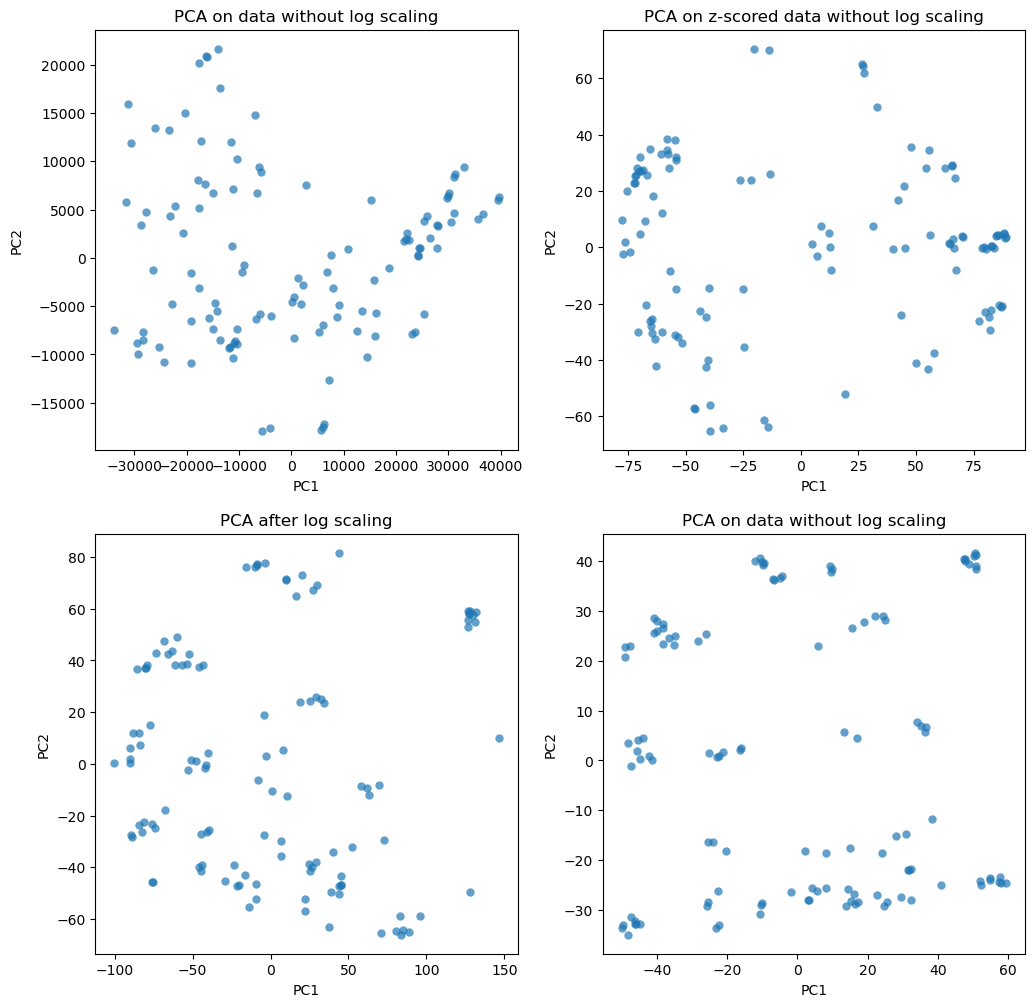

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(12,12), dpi=100)
axs = axs.flatten()

def scatter_plot(df, x, y, ax, labels=None, title="", palette='tab10'):
    sns.scatterplot(x=x, y=y, data=df,
                    ax=ax,
                    alpha=0.7, # opacity of the points
                    linewidth=0, # outline of the data points
                    hue=labels,
                    palette=palette)
    ax.set_title(title)

scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[0], title="PCA on data without log scaling")
scatter_plot(z_real_PCs_df, 'PC1', 'PC2', axs[1], title="PCA on z-scored data without log scaling")
scatter_plot(log_real_PCs_df, 'PC1', 'PC2', axs[2], title="PCA after log scaling")
scatter_plot(z_log_real_PCs_df, 'PC1', 'PC2', axs[3], title="PCA on data without log scaling")

In [15]:
#ML testing

In [16]:
log_expr_df_trans.head()

Synt,Syntelog_00001,Syntelog_00002,Syntelog_00003,Syntelog_00004,Syntelog_00005,Syntelog_00006,Syntelog_00007,Syntelog_00008,Syntelog_00009,Syntelog_00010,...,Syntelog_18417,Syntelog_18418,Syntelog_18419,Syntelog_18420,Syntelog_18422,Syntelog_18423,Syntelog_18424,Syntelog_18425,Syntelog_18426,Syntelog_18428
D14NAR1,4.733178,0.0,0.575829,2.279747,3.581198,0.848928,0.279276,1.113975,3.198467,1.789418,...,0.000000,0.000000,2.453714,0.0,0.595389,0.765971,0.0,0.0,0.000000,0.000000
D14NAR2,4.783843,0.0,0.888119,2.617122,3.525803,1.006562,0.196260,1.083804,3.417136,2.056713,...,0.000000,0.000000,1.854890,0.0,0.000000,0.476660,0.0,0.0,0.056812,0.000000
D14NAR3,4.715559,0.0,0.974897,2.476458,3.582839,1.133458,0.572177,1.171386,3.374494,1.671603,...,0.000000,0.455139,1.812325,0.0,0.332410,0.582822,0.0,0.0,0.086562,0.103320
D21NAR1,3.443483,0.0,1.076046,2.234144,3.666772,1.349304,0.000000,0.815982,3.620936,1.897044,...,0.000000,0.000000,0.000000,0.0,0.524112,0.618374,0.0,0.0,0.046690,0.000000
D21NAR2,6.960495,0.0,1.549048,3.767367,3.937046,1.843247,3.450608,0.201247,4.721716,3.822519,...,1.463252,3.590638,0.000000,0.0,0.000000,5.201117,0.0,0.0,1.054072,4.625122


In [17]:
ML_labels = pd.read_csv('ML_labels.txt', delimiter='\t')
ML_labels.head()

,Synt,Treatment
0,D14NAR1,1
1,D14NAR2,1
2,D14NAR3,1
3,D21NAR1,1
4,D21NAR2,1


In [18]:
#log_expr_df_trans.set_index('GeneID', inplace=True)
ML_labels.set_index('Synt', inplace=True)

In [19]:
merged_df = log_expr_df_trans.merge(ML_labels, left_index=True, right_index=True)

In [20]:
merged_df.shape

(117, 16891)

In [21]:
expr_ML = expr_df_trans.merge(ML_labels, left_index=True, right_index=True)
expr_ML_clean = expr_ML.dropna()
expr_ML_clean.shape

(117, 16891)

In [48]:
# Separate features (gene expression values) and target (class labels)
X = expr_ML_clean.iloc[:, 1:-1]  # Gene expression values
y = expr_ML_clean.iloc[:, -1].astype(int)    # Class labels

# Split the data into training (75%) and testing (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9666666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.94      0.97        17

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [49]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier

# Choose the index of the tree you want to evaluate (e.g., 0 for the first tree)
tree_index = 0

# Extract the decision tree from the random forest
tree: DecisionTreeClassifier = rf_classifier.estimators_[tree_index]

# Make predictions using the decision tree
y_pred_tree = tree.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred_tree)
classification_report_tree = classification_report(y_test, y_pred_tree)

# Print the performance metrics
print(f"Performance Metrics for Tree {tree_index}:")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_tree)

Performance Metrics for Tree 0:
Accuracy: 0.8333333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.88      0.82      0.85        17

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30



In [50]:
# Choose the index of the tree you want to find the depth of (e.g., 0 for the first tree)
tree_index = 0

# Extract the decision tree from the random forest
tree: DecisionTreeClassifier = rf_classifier.estimators_[tree_index]

# Get the depth of the decision tree
tree_depth = tree.get_depth()

# Print the depth of the decision tree
print(f"Depth of Tree {tree_index}: {tree_depth}")

Depth of Tree 0: 2


In [47]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Separate features (gene expression values) and target (class labels)
X = expr_ML_clean.iloc[:, 1:-1]  # Gene expression values
y = expr_ML_clean.iloc[:, -1].astype(int)    # Class labels

# Set the metadata attribute of the X DataFrame
X.metadata = X.columns

# Split the data into training (75%) and testing (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9666666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.94      0.97        17

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [46]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier

# Choose the index of the tree you want to evaluate (e.g., 0 for the first tree)
tree_index = 0

# Extract the decision tree from the random forest
tree: DecisionTreeClassifier = rf_classifier.estimators_[tree_index]

# Make predictions using the decision tree
y_pred_tree = tree.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred_tree)
classification_report_tree = classification_report(y_test, y_pred_tree)

# Print the performance metrics
print(f"Performance Metrics for Tree {tree_index}:")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_tree)

Performance Metrics for Tree 0:
Accuracy: 0.8333333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.88      0.82      0.85        17

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30



In [43]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a list of (feature, importance) tuples
feature_importance_list = list(zip(X.columns, feature_importances))

# Sort the list by importance in descending order
sorted_feature_importance_list = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# Print the feature importances
print("Feature Importances:")
#for feature, importance in sorted_feature_importance_list:
 #   print(f"{feature}: {importance}")

Feature Importances:


In [ ]:
import numpy as np
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=UserWarning)
# Get the number of trees in the Random Forest
n_trees = len(rf_classifier.estimators_)

# Create a dictionary to store feature importances for classifying 1 over 0
feature_importances_1_over_0 = {feature: 0 for feature in X.columns}

# Loop through each tree in the Random Forest
for tree in rf_classifier.estimators_:
    # Get the decision path for the tree
    decision_path = tree.decision_path(X)

    # Get the predicted classes for the entire dataset
    predicted_classes = tree.predict(X)

    # Loop through each sample in the dataset
    for sample_idx in range(X.shape[0]):
        # Check if the sample is classified as class 1
        if predicted_classes[sample_idx] == 1:
            # Get the feature indices used for the decision path of this sample
            feature_indices = decision_path.indices[decision_path.indptr[sample_idx]:decision_path.indptr[sample_idx + 1]]

            # Increment the importance of each feature used in the decision path
            for feature_idx in feature_indices:
                feature_name = X.columns[tree.tree_.feature[feature_idx]]
                feature_importances_1_over_0[feature_name] += 1

# Normalize the feature importances
total_importances = sum(feature_importances_1_over_0.values())
feature_importances_1_over_0 = {feature: importance / total_importances for feature, importance in feature_importances_1_over_0.items()}

# Create a list of (feature, importance) tuples and sort by importance
sorted_feature_importances_1_over_0 = sorted(feature_importances_1_over_0.items(), key=lambda x: x[1], reverse=True)

# Print the feature importances for classifying 1 over 0
print("Feature Importances for Classifying 1 over 0:")
for feature, importance in sorted_feature_importances_1_over_0:
    print(f"{feature}: {importance}")

In [17]:
raw_labels = pd.read_csv("labels.txt")
raw_labels = raw_labels.set_index('Sample')
raw_labels.head()

,Species,Watering_state,Name,Tissue
Sample,,,,
D14NAR1,Othomaeum,D,D14NAR1,leaf
D14NAR2,Othomaeum,D,D14NAR2,leaf
D14NAR3,Othomaeum,D,D14NAR3,leaf
D21NAR1,Othomaeum,D,D21NAR1,leaf
D21NAR2,Othomaeum,D,D21NAR2,leaf


In [18]:
raw_labels.columns

Index(['Species', 'Watering_state', 'Name', 'Tissue'], dtype='object')

In [19]:
labeling_rows = []

columns =[('Species', 'Species'), 
           ('Watering_state', 'Watering_state'), 
           ('Name', 'Name'), ('Tissue', 'Tissue')]

for srr in list(expr_df_trans.index):
    entry = raw_labels.loc[srr]
    row = {'Sample' : srr}
    for old_colname, new_colname in columns:
        row[new_colname] = entry[old_colname]
    labeling_rows.append(row)

label_df = pd.DataFrame(labeling_rows)
label_df

,Sample,Species,Watering_state,Name,Tissue
0,D14NAR1,Othomaeum,D,D14NAR1,leaf
1,D14NAR2,Othomaeum,D,D14NAR2,leaf
2,D14NAR3,Othomaeum,D,D14NAR3,leaf
3,D21NAR1,Othomaeum,D,D21NAR1,leaf
4,D21NAR2,Othomaeum,D,D21NAR2,leaf
...,...,...,...,...,...
112,Et_D24pmR2,Etef,D,Et_D24pmR2,leaf
113,Et_D24pmR3,Etef,D,Et_D24pmR3,leaf
114,Et_WW4pmR1,Etef,WW,Et_WW4pmR1,leaf
115,Et_WW4pmR2,Etef,WW,Et_WW4pmR2,leaf


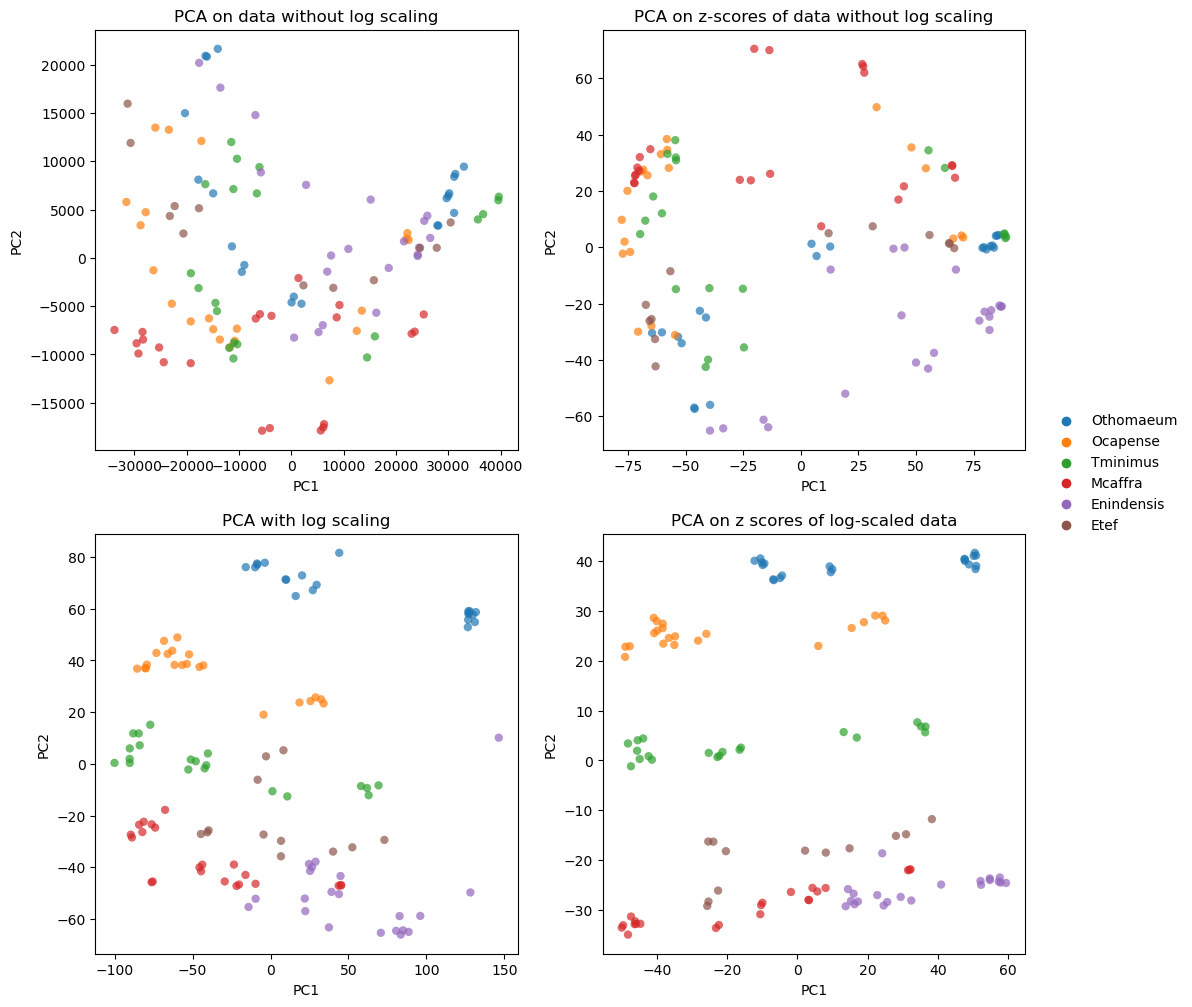

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(12,12), dpi=100)
axs = axs.flatten()

labels = label_df['Species'] 

scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[0], labels, "PCA on data without log scaling")
scatter_plot(z_real_PCs_df, 'PC1', 'PC2', axs[1], labels, "PCA on z-scores of data without log scaling")
scatter_plot(log_real_PCs_df, 'PC1', 'PC2', axs[2], labels, "PCA with log scaling")
scatter_plot(z_log_real_PCs_df, 'PC1', 'PC2', axs[3], labels, "PCA on z scores of log-scaled data")

for ax in axs:
    if ax.get_legend(): # legend could be Nonetype
        ax.get_legend().set_visible(False)
axs[1].legend(bbox_to_anchor=(1.05, 0.1), loc=2, borderaxespad=0., frameon=False)
plt.savefig('PCA_chloridoids_species.pdf')

In [23]:
label_df

,Sample,Species,Watering_state,Name,Tissue
0,D14NAR1,Othomaeum,D,D14NAR1,leaf
1,D14NAR2,Othomaeum,D,D14NAR2,leaf
2,D14NAR3,Othomaeum,D,D14NAR3,leaf
3,D21NAR1,Othomaeum,D,D21NAR1,leaf
4,D21NAR2,Othomaeum,D,D21NAR2,leaf
...,...,...,...,...,...
112,Et_D24pmR2,Etef,D,Et_D24pmR2,leaf
113,Et_D24pmR3,Etef,D,Et_D24pmR3,leaf
114,Et_WW4pmR1,Etef,WW,Et_WW4pmR1,leaf
115,Et_WW4pmR2,Etef,WW,Et_WW4pmR2,leaf


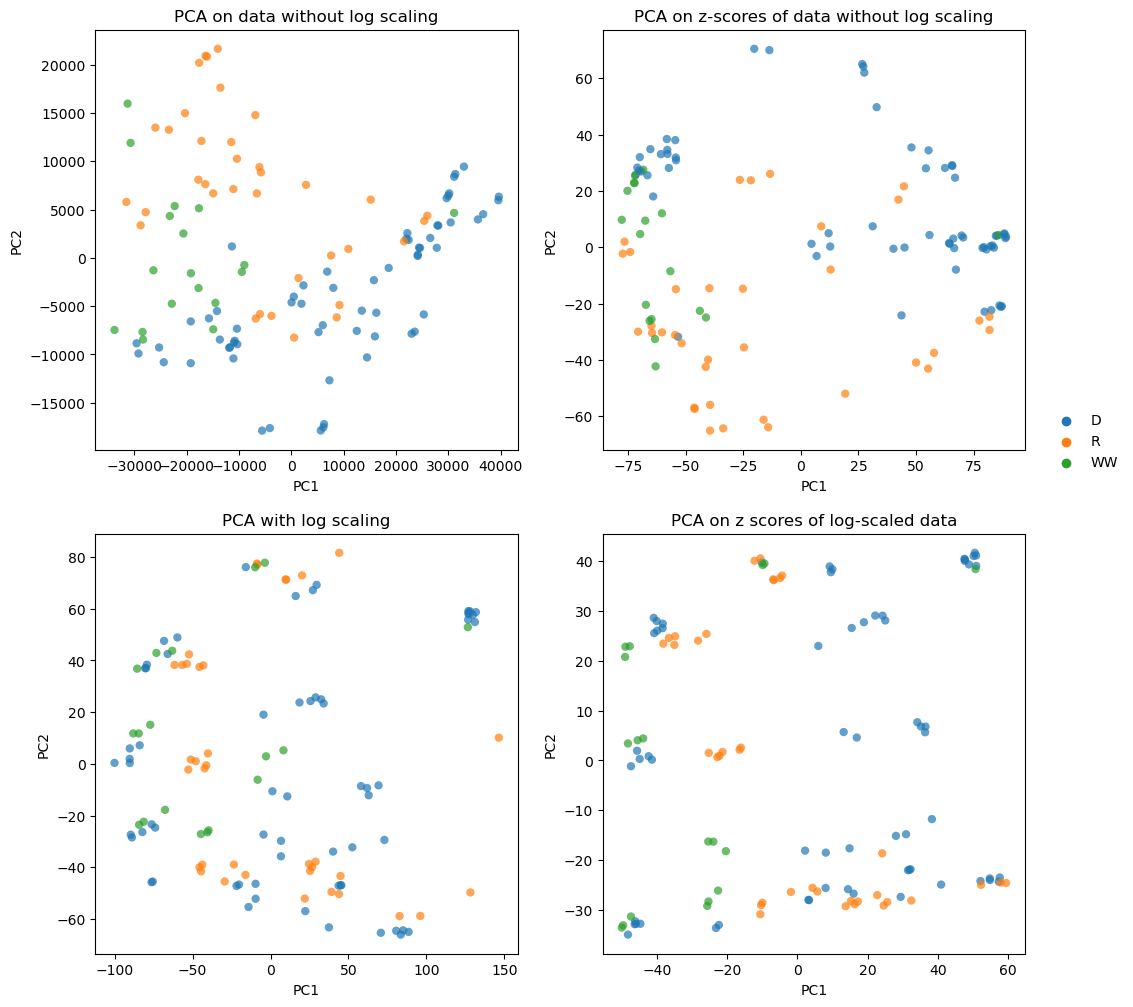

In [220]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(12,12), dpi=100)
axs = axs.flatten()

labels = label_df['Watering_state'] 

scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[0], labels, "PCA on data without log scaling")
scatter_plot(z_real_PCs_df, 'PC1', 'PC2', axs[1], labels, "PCA on z-scores of data without log scaling")
scatter_plot(log_real_PCs_df, 'PC1', 'PC2', axs[2], labels, "PCA with log scaling")
scatter_plot(z_log_real_PCs_df, 'PC1', 'PC2', axs[3], labels, "PCA on z scores of log-scaled data")

for ax in axs:
    if ax.get_legend(): # legend could be Nonetype
        ax.get_legend().set_visible(False)
axs[1].legend(bbox_to_anchor=(1.05, 0.1), loc=2, borderaxespad=0., frameon=False)
plt.savefig('PCA_chloridoids_hydration.pdf')

In [215]:
# Dimension reduction with MDS and t-SNE
from sklearn.manifold import MDS

def apply_mds(data, num_dim=2, return_object=False):
    """
    data : data to fit MDS on
    num_dim : Number of dimensions of reduced data
    return_object : should the function also return the MDS object
    """
    mds = MDS(n_components=num_dim)
    real_MDS = mds.fit_transform(data)
    real_MDS_df = pd.DataFrame(data=real_MDS, columns=[f'MDS{i}' for i in range(1, num_dim+1)])
    if return_object:
        return real_MDS_df, mds
    else:
        return real_MDS_df

In [216]:
from sklearn.manifold import TSNE
    
def apply_tsne(data, num_dim=2, return_object=False):
    """
    data : data to fit t-SNE on
    num_dim : Number of dimensions of reduced data
    return_object : should the function also return the t-SNE object 
    """
    tsne = TSNE(n_components=num_dim)
    real_TSNE = tsne.fit_transform(data)
    real_TSNE_df = pd.DataFrame(data=real_TSNE, columns=[f'tSNE{i}' for i in range(1, num_dim+1)])
    if return_object:
        return real_TSNE_df, tsne
    else:
        return real_TSNE_df

In [217]:
tsne_df = apply_tsne(expr_df_zscore)
mds_df = apply_mds(expr_df_zscore)

C:\Users\Bob\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Bob\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


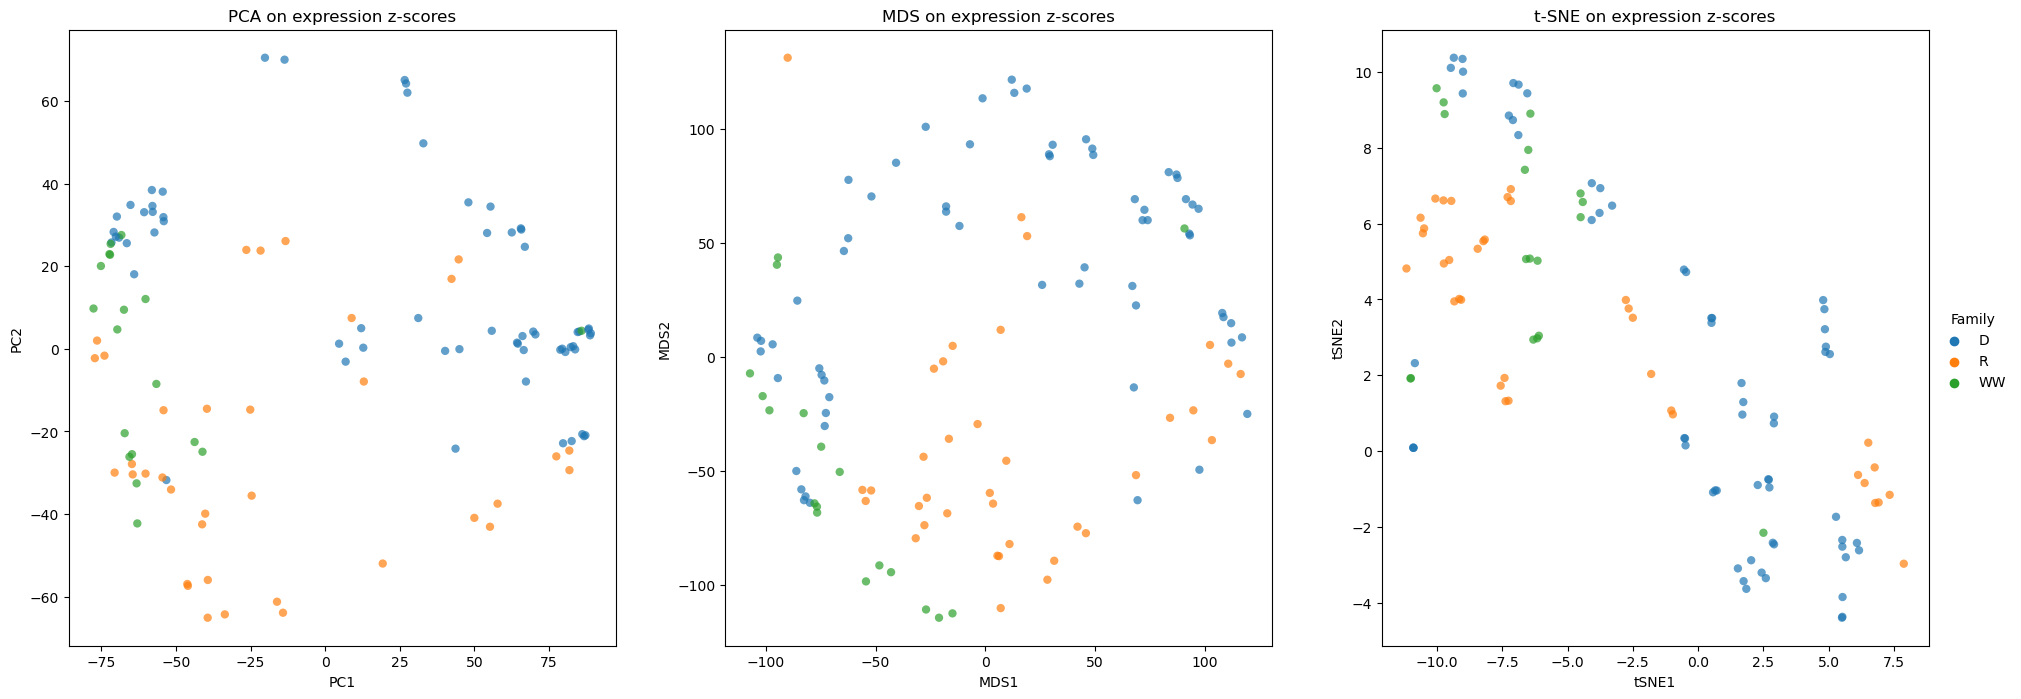

In [218]:
fig, axs = plt.subplots(1,3, figsize=(24,8), dpi=100)
axs=axs.flatten()

scatter_plot(z_real_PCs_df, 'PC1', 'PC2', axs[0], labels, "PCA on expression z-scores")
scatter_plot(mds_df, 'MDS1', 'MDS2', axs[1], labels, "MDS on expression z-scores")
scatter_plot(tsne_df, 'tSNE1', 'tSNE2', axs[2], labels, "t-SNE on expression z-scores")

for ax in axs:
    if ax.get_legend(): # legend could be Nonetype
        ax.get_legend().set_visible(False)
axs[2].legend(bbox_to_anchor=(1.01, 0.55), loc=2, borderaxespad=0., frameon=False, title="Family")